In [30]:
import pandas as pd
import os
import re
import gensim
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from IPython.display import HTML
from tensorflow import keras
from keras import backend as K
from keras.models import load_model
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM, Bidirectional
from keras.utils import plot_model
from keras.utils import to_categorical
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, feature_selection
import spacy
import en_core_web_lg

In [4]:
csv_file = os.getcwd() + os.sep + os.sep.join(['csv' , 'summary2.csv'])

corpus=pd.read_csv(csv_file, dtype=str)
corpus=corpus.dropna(subset=['summ'])
print(corpus.summ)

C:\Users\Hawkins\OneDrive\MSAI\DS Seminar\summary2.csv
0                                             NO AFFIDAVIT
1        The Compl alleged that his girlfriend, PO Barn...
2                                            NOT SUSTAINED
3                                     Punched\nin his face
4                                           (None Entered)
                               ...                        
46892    The reporting party\ninformed the officers\nli...
46893    The reporting party alleges that the accused\n...
46894    The reporting party alleges that the accused\n...
46895    The complainan alleged that on unknown date an...
46896    has not investigated HV-\nThe reporting\nstate...
Name: summ, Length: 46897, dtype: object


Pre-processing and Lemmatizing

In [5]:
summary_df=corpus
en_core = en_core_web_lg.load()
summary_df['summary_text_processed1'] = summary_df['summ'].map(lambda x: re.sub('[,\.!?]()', '', x))

# convert to lower
summary_df['summary_text_processed2'] = summary_df['summary_text_processed1'].map(lambda x: x.lower())

# lemmatize
summary_df['summary_text_processed3'] = summary_df['summary_text_processed2'].map(lambda x: " ".join([y.lemma_ for y in en_core(x)]))


In [6]:
pattern = '(18|19|20)[0-9][0-9]'
summary_df['summary_text_processed4'] = summary_df['summary_text_processed3'].map(lambda x: re.sub(pattern, '', x))
stopwords = set(['cook county','chicago','allegedly','po','ofcer','sergeant','ipra','detective','accused', 'officer', 'officers', 'reporting', 'party', 'alleged', 'alleges', 'complainant', 'victim', 'police', '-pron-', 'pron', '-PRON-', '[-PRON-]', 'allege', 'accuse', 'report'])
stopwords= (stopwords.union(en_core.Defaults.stop_words))
summary_df['summary_text_processed'] = summary_df['summary_text_processed4'].map(lambda x: " ".join([item for item in x.split() if item not in stopwords]))
print(summary_df['summary_text_processed'][501])

texts = [re.sub('[^A-Za-z ]+',' ', line) for line in summary_df['summary_text_processed']]
text = [[word.lower() for word in text.split()] for text in texts]


( enter )


In [7]:
summary_df.head()

,summ,id,district,hospitals,summary_text_processed1,summary_text_processed2,summary_text_processed3,summary_text_processed4,summary_text_processed
0,NO AFFIDAVIT,46504,NaN,NaN,NO AFFIDAVIT,no affidavit,no affidavit,no affidavit,affidavit
1,"The Compl alleged that his girlfriend, PO Barn...",46505,NaN,NaN,The Compl alleged that his girlfriend PO Barne...,the compl alleged that his girlfriend po barne...,the compl allege that -PRON- girlfriend po bar...,the compl allege that -PRON- girlfriend po bar...,compl girlfriend barnes throw drink face slap
2,NOT SUSTAINED,46888,22nd,NaN,NOT SUSTAINED,not sustained,not sustain,not sustain,sustain
3,Punched\nin his face,46889,22nd,NaN,Punched\nin his face,punched\nin his face,punch \n in -PRON- face,punch \n in -PRON- face,punch face
4,(None Entered),45622,12th,6,(None Entered),(none entered),( none enter ),( none enter ),( enter )


Creating word vectors:

In [8]:
model_new = Word2Vec(text, size=300)
model_new.wv.save_word2vec_format('word_embeddings_300d.txt', binary=False)
model_new.wv.save_word2vec_format('word_embeddings.bin', binary=True)

In [9]:
print(model_new.wv.most_similar('ambulance'))

[('christ', 0.8132261633872986), ('hospital', 0.7974581122398376), ('ignore', 0.7715891599655151), ('cfd', 0.755982518196106), ('heart', 0.7517737746238708), ('resurrection', 0.7446479797363281), ('treat', 0.7396096587181091), ('mary', 0.7376938462257385), ('mccambry', 0.7344667911529541), ('attention', 0.7287854552268982)]


In [10]:
max_words=10000
maxlen=2000
tokenize=Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789', lower=True)
tokenize.fit_on_texts(summary_df['summary_text_processed'])
sequences = tokenize.texts_to_sequences(summary_df['summary_text_processed'])
word_index=tokenize.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18244 unique tokens.


In [11]:
print(tokenize.word_counts['concussion'])

8


C:\Users\Hawkins\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
C:\Users\Hawkins\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Hawkins\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<Figure size 432x288 with 0 Axes>

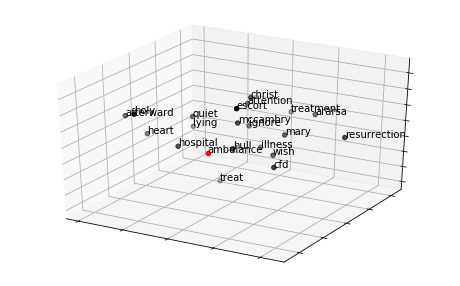

In [12]:
word = "ambulance"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 model_new.most_similar(word, topn=20)]
X = model_new[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

Labeling Data:

In [13]:
#find examples with this
df=pd.DataFrame()
df['summ']=summary_df['summary_text_processed']
df['label']=0
df['id']=summary_df['id']


label_makers=['doctor','medical','hospital','resurrection', 'ambulance', 'ems','diagnose','oemc','diabetes','medicine','asthma','stroger','treatment','pandemic','covenant','health', 'concussion', 'breathing', 'spinal', 'surgery', 'fractured', 'fracture', 'trauma', 'consciousness', 'contusion', 'swell', 'blood', 'gash']
for allegation in df.summ:
    for word in allegation.split():
        if word in label_makers:
            df.loc[df.summ==allegation,'label']= 1

# Naive Bayes Modeling w/ Bag of Words

In [14]:
print(df.head())

## split dataset
dtf_train, dtf_test = model_selection.train_test_split(df, test_size=0.3)
## get target
y_train = dtf_train['label'].values
y_test = dtf_test['label'].values


                                            summ  label     id
0                                      affidavit      0  46504
1  compl girlfriend barnes throw drink face slap      0  46505
2                                        sustain      0  46888
3                                     punch face      0  46889
4                                      ( enter )      0  45622


In [15]:
## Count (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [16]:
corpus = dtf_train["summ"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [21]:
classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["summ"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)[:,1]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13668
           1       0.87      0.27      0.41       402

    accuracy                           0.98     14070
   macro avg       0.92      0.63      0.70     14070
weighted avg       0.98      0.98      0.97     14070



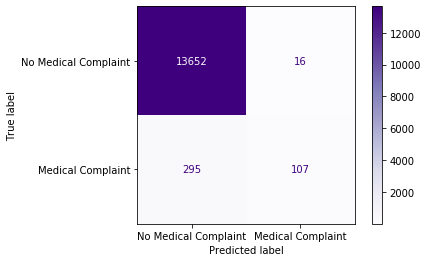

In [22]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
#auc = metrics.roc_auc_score(y_test, predicted_prob)
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
# Printing Confusion Matrix
cm = confusion_matrix(y_test, predicted)
target_names = ['No Medical Complaint', 'Medical Complaint']
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp = disp.plot(cmap='Purples', values_format='.0f')
plt.show()

In [23]:
# Printing Classification Report
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob)
youden_values = list(tpr - fpr)
youden_index = youden_values.index(max(youden_values))
optimal_threshold = thresholds[youden_index]
trans = np.vectorize(lambda x: 1 if x > optimal_threshold else 0)
y_pred =  trans(predicted_prob)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     13668
           1       0.23      0.86      0.36       402

    accuracy                           0.91     14070
   macro avg       0.61      0.89      0.66     14070
weighted avg       0.97      0.91      0.94     14070



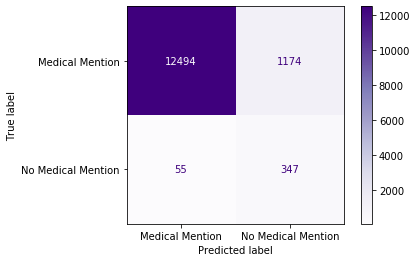

In [24]:
# Printing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
target_names = ['Medical Mention', 'No Medical Mention']
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp = disp.plot(cmap='Purples', values_format='.0f')
plt.show()

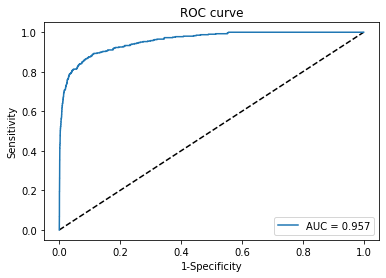

In [25]:
# ROC curve
from sklearn.metrics import roc_curve, auc, classification_report

# Plotting ROC
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob)
auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='lower right')
# plt.savefig('/deepcovidxr/Ramsey_Keras/Resnet.pdf')
plt.show()

# Medical Complaints vs Hospitals per District

In [27]:
#find examples with this
df=pd.DataFrame()
df['summ']=summary_df['summary_text_processed']
df['label']=0
df['district']=summary_df['district']


label_makers=['doctor','medical','hospital','resurrection', 'ambulance', 'ems','diagnose','oemc','diabetes','medicine','asthma','stroger','treatment','pandemic','covenant','health', 'concussion', 'breathing', 'spinal', 'surgery', 'fractured', 'fracture', 'trauma', 'consciousness', 'contusion', 'swell', 'blood', 'gash']
for allegation in df.summ:
    for word in allegation.split():
        if word in label_makers:
            df.loc[df.summ==allegation,'label']= 1
print(df.label.sum())

1312


In [28]:
df['hospitals']=summary_df['hospitals']
district_list={'1st':[0,0,0], '2nd':[0,0,0], '3rd':[0,0,0], '4th':[0,0,0], '5th':[0,0,0], '6th':[0,0,0], '7th':[0,0,0], '8th':[0,0,0], '9th':[0,0,0], '10th':[0,0,0], '11th':[0,0,0], '12th':[0,0,0], '14th':[0,0,0],
               '15th':[0,0,0], '16th':[0,0,0] , '17th':[0,0,0], '18th':[0,0,0], '19th':[0,0,0], '20th':[0,0,0], '22nd':[0,0,0],
               '24th':[0,0,0],'25th':[0,0,0], '31th':[0,0,0]}
df=df.dropna(subset=['district'])

for i,line in df.iterrows():
    if line['district'] in district_list.keys():
        if line['label']==0:
            district_list[line['district']][0] += 1
            district_list[line['district']][1] += 0
        else:
            district_list[line['district']][0] += 1
            district_list[line['district']][1] += 1
        if type(line['hospitals'])==str:
            district_list[line['district']][2] = int(line['hospitals'])

print(district_list)

{'1st': [1831, 45, 1], '2nd': [2499, 80, 2], '3rd': [2746, 47, 1], '4th': [2510, 43, 3], '5th': [2350, 51, 1], '6th': [3086, 39, 0], '7th': [2729, 39, 1], '8th': [2686, 55, 1], '9th': [2025, 32, 0], '10th': [1680, 31, 3], '11th': [3131, 43, 3], '12th': [1306, 49, 6], '14th': [1117, 15, 1], '15th': [1746, 17, 1], '16th': [1306, 24, 3], '17th': [775, 18, 1], '18th': [1741, 53, 3], '19th': [1563, 41, 6], '20th': [780, 11, 3], '22nd': [1694, 24, 0], '24th': [1226, 12, 1], '25th': [1980, 50, 1], '31th': [669, 28, 0]}


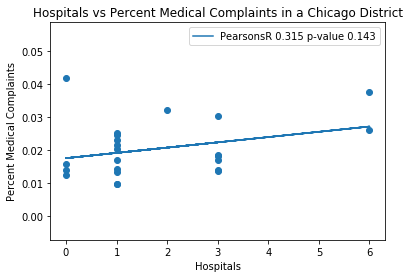

Percent PearsonsR 0.3149048889235878 with p value 0.14331758781108853


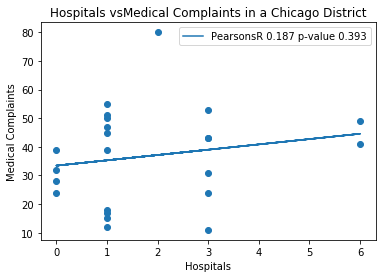

Percent PearsonsR 0.1868903251464633 with p value 0.3931761624336201


In [29]:
allegations=[]
medical=[]
hospitals=[]
for key, value in district_list.items():
    allegations.append(value[0])
    medical.append(value[1])
    hospitals.append(value[2])


hospitals=np.array(hospitals)
medical=np.array(medical)
allegations=np.array(allegations)
y=[]

for i in range(0,len(medical)):
    y.append(medical[i]/allegations[i])


import matplotlib.pyplot as plt
from scipy.stats import pearsonr

fig=plt.figure()
plt.scatter(hospitals,y)
m, b = np.polyfit(hospitals, y, 1)
coa1=pearsonr(hospitals, y)
line, =plt.plot(hospitals, m*hospitals + b)
plt.title('Hospitals vs Percent Medical Complaints in a Chicago District')
plt.xlabel('Hospitals')
plt.ylabel('Percent Medical Complaints')
line.set_label(f'PearsonsR {round(coa1[0],3)} p-value {round(coa1[1],3)}')
plt.legend()
plt.savefig('q3.png')
plt.show()
print(f'Percent PearsonsR {coa1[0]} with p value {coa1[1]}')

fig=plt.figure()
plt.scatter(hospitals,medical)
plt.title('Hospitals vsMedical Complaints in a Chicago District')
m, b = np.polyfit(hospitals, medical, 1)
coa2=pearsonr(hospitals, medical)
line2, =plt.plot(hospitals, m*hospitals + b)
line2.set_label(f'PearsonsR {round(coa2[0],3)} p-value {round(coa2[1],3)}')
plt.xlabel('Hospitals')
plt.ylabel('Medical Complaints')
plt.legend()
plt.savefig('q4.png')
plt.show()
print(f'Percent PearsonsR {coa2[0]} with p value {coa2[1]}')